In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [60]:
PICKLE_PATH = '../augmented_datasets/pickles/final_data/hopkins_conf_narrow_0605.pkl'
OUTLIER_QUARTILES = (0.02, 0.98) # Min, max quartiles

In [116]:
def remove_outlier(df, range_, columns):
    low = range_[0]
    high = range_[1]
    qnt = df.quantile([low, high])
    data = df.copy()
    for col in list(columns):
        data[col] = \
            data[(data[col] > qnt.loc[low, col]) &\
               (data[col] < qnt.loc[high, col])][col]
    return data.dropna()

def calc_corrs_scatter(df, outliers=(0,0), gdp_thr=0, urb_thr=0, only_us=False,\
                       show_names=False, show_states=False, temp_outliers=(0,0)):

    targets = ['GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']

    for target in targets:
        print('Interval temp vs {0} correlations'.format(target))
        if outliers == (0,0):
            confs1 = df.copy()
        else:
            confs1 = remove_outlier(df, outliers, [target])
        if temp_outliers != (0,0):
            confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
        confs1.dropna(inplace=True)
        if only_us:
            confs1 = confs1[confs1['Country_Region'] == 'US']
        confs1 = confs1[confs1['GDP'] > gdp_thr]
        confs1 = confs1[confs1['Urbanization'] > urb_thr]       
        gf = confs1[target].loc[:,'data'].values.tolist()
        avg_int_tmp = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

        corr_p1 = stats.pearsonr(gf, avg_int_tmp)
        corr_s1 = stats.spearmanr(gf, avg_int_tmp)

        print('n={0}'.format(len(gf)))
        print('Pearson: {0}\tOne sided p_value: {1}'.format(corr_p1[0], corr_p1[1] / 2))
        print('Spearman: {0}\tOne sided p_value: {1}\n'.format(corr_s1[0], corr_s1[1] / 2))

    if outliers == (0,0):
        confs1 = df.copy()
    else:
        confs1 = remove_outlier(df, outliers, ['GF_Q1'])
    if temp_outliers != (0,0):
        confs1 = remove_outlier(confs1, temp_outliers, ['avg_interval_tmp'])
    if only_us:
        confs1 = confs1[confs1['Country_Region'] == 'US']
    confs1 = confs1[confs1['GDP'] > gdp_thr]
    confs1 = confs1[confs1['Urbanization'] > urb_thr]       
    
    confs1.dropna(inplace=True)
    
    gf_q1_1 = confs1['GF_Q1'].loc[:,'data'].values.tolist()
    avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

    fig, axes = plt.subplots(figsize=(15, 7))
    _ = axes.scatter(avg_int_tmp1, gf_q1_1)
    n = len(gf_q1_1)

    _ = axes.set_xlabel('avg interval temp')
    _ = axes.set_ylabel('Q1 GF')
    _ = axes.set_title('n={0}'.format(n))

    if show_names:
        countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(countries1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))

    if show_states and not show_names:
        states1 = confs1['Province_State'].loc[:,'data'].values.tolist()
        for i, txt in enumerate(states1):
            _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))
def manual_WRS(gf_qx, cold, hot):
    
    colds = cold[[gf_qx]]
    hots = hot[[gf_qx]]
    
#     colds = cold[gf_qx]
#     hots = hot[gf_qx]

    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)

    colds.rename(columns={gf_qx: ''}, inplace=True)
    hots.rename(columns={gf_qx: ''}, inplace=True)

    # manual WRS algorithm

    colds = colds.T
    hots = hots.T
    colds = colds.add_prefix('c')
    hots = hots.add_prefix('h')
    ranks = colds.join(hots, lsuffix='first').rank(axis=1)
    
    h_list = [sample for sample in ranks.columns if 'h' in sample]
    c_list = [sample for sample in ranks.columns if 'c' in sample]
    h_sum = ranks[h_list].sum(axis=1)
    c_sum = ranks[c_list].sum(axis=1)

    b = len(colds.columns)
    n = b + len(hots.columns)
    expected_cold_sum = (b * (n + 1)) / 2
    sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

    sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
    p_value = 1 - sums_normal.cdf(float(c_sum))
    
    size = {
           'colds': b,
           'hots': len(hots.columns)
           }
    
    return {'expected': expected_cold_sum, 
            'attained': c_sum, 
            'p': p_value, 
            'sigma': sigma, 
            'size': size}

def print_manual_WRS(qx, qx_results):
    difference = qx_results[1] - qx_results[0]
    print('--------------------------------------------------')
    print('{} WRS (manual)'.format(qx))
    print('--------------------------------------------------')
    print(
         '# colds samples: {0}\n# of hots samples: {1}\n'
         'Expected mean for cold countries rank sum: {2}\n'
         'Attained mean for cold countries rank sum: {3}\n'
         'Sigma: {4}\n'
         '(Attained mean) - (Expected mean) = {5}\n'
         'p-value for this result is: {6}'
         .format(qx_results[4]['colds'], qx_results[4]['hots'], qx_results[0],\
                 qx_results[1], difference, qx_results[3], qx_results[2]))

def builtin_WRS(gf_qx, cold, hot):#df, temp_range):
    colds = cold[[gf_qx]]
    hots = hot[[gf_qx]]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ranksums(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}

def print_builtin_WRS(qx, qx_results):
    print('--------------------------------------------------')
    print('{} WRS (built-in) '.format(qx))
    print('--------------------------------------------------')
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
#     print('--------------------------------------------------')


def builtin_ttest(gf_qx, cold, hot):#df, temp_range):
    colds = cold[[gf_qx]]
    hots = hot[[gf_qx]]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ttest_ind(colds, hots)
    size = {
           'colds': len(colds),
           'hots': len(hots)
           }
    return {'t':t, 
            'p':p, 
            'size':size}


def print_builtin_ttest(qx, qx_results):
    print('--------------------------------------------------')
    print('{} TTest (built-in)'.format(qx))
    print('--------------------------------------------------')
    print('# colds: {0}\n# of hots: {1}'.format(qx_results[2]['colds'], qx_results[2]['hots']))
    print('Statistic:\t{0}'.format(qx_results[0]))
    print('p-value:\t{0}'.format(qx_results[1]))
    print('--------------------------------------------------')

def calc_wrs_ttest(colds, hots):#, temp_range):
    Q1_manual = manual_WRS('GF_Q1', colds, hots)#df, temp_range)
    print_manual_WRS('Q1', Q1_manual)

    Q1_builtin = builtin_WRS('GF_Q1', colds, hots)#df, temp_range)
    print_builtin_WRS('Q1', Q1_builtin)
    
    Q1_ttest = builtin_ttest('GF_Q1', colds, hots)#df, temp_range)
    print_builtin_ttest('Q1', Q1_ttest)
    
#     Q3_manual = manual_WRS('GF_Q3', df)
#     print_manual_WRS('Q3', Q3_manual)

#     Q3_builtin = builtin_WRS('GF_Q3', df)
#     print_builtin_WRS('Q3', Q3_builtin)

#     Q3_ttest = builtin_ttest('GF_Q3', df)
#     print_builtin_ttest('Q3', Q3_ttest)     

In [25]:
hopkins_confirmed = pd.read_pickle(PICKLE_PATH)
# these are unique to US and will cause problems here
hopkins_confirmed.drop(columns=['State Population', 'Total Tests', 'Tests \ Pop'], inplace=True)
hopkins_confirmed.dropna(inplace=True)

In [26]:
PLAIN = {'df': hopkins_confirmed,
        'show_names': True
        }

OUTLIERS = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98)
            }

GDP_URB1 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 30000,
            'urb_thr': 80
            }

GDP_URB2 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 36000,
            'urb_thr': 84
            }

GDP_URB3 = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'gdp_thr': 43000,
            'urb_thr': 88
            }

US_ONLY = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'only_us': True,
            'show_states': True
            }

TEMP_OUTLIERS = {
            'df': hopkins_confirmed,
            'outliers': (0.02,0.98),
            'temp_outliers': (0.1, 0.9)
            }

In [27]:
hopkins_confirmed.describe()
us_states = len(hopkins_confirmed[hopkins_confirmed['Country_Region'] == 'US'])
print('Of which {0} are US locations'.format(us_states))

,GDP,Urbanization,Median Age,Democracy,Gini Index,Tests per 1M,avg_mobility,avg_interval_RH,avg_interval_tmp,avg_m_tmp,...,4/27/2020,4/28/2020,4/29/2020,4/30/2020,5/1/2020,5/2/2020,5/3/2020,5/4/2020,5/5/2020,5/6/2020
count,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,...,1819.000000,1.819000e+03,1.819000e+03,1.819000e+03,1.819000e+03,1.819000e+03,1.819000e+03,1.819000e+03,1.819000e+03,1.819000e+03
mean,53090.372813,73.070461,37.536669,7.688873,40.936200,34304.648641,16.887475,66.191967,13.684071,10.329773,...,2194.726223,2.248463e+03,2.304616e+03,2.367231e+03,2.432763e+03,2.493992e+03,2.551085e+03,2.605198e+03,2.661828e+03,2.725957e+03
std,17366.872349,13.592847,3.766958,1.150619,2.594742,9173.460346,3.564068,9.396912,6.106172,6.592512,...,25822.142738,2.642000e+04,2.707243e+04,2.778648e+04,2.859091e+04,2.930567e+04,2.993265e+04,3.049183e+04,3.109432e+04,3.173247e+04
min,389.398033,16.425000,15.100000,1.130000,24.200000,92.000000,3.000000,9.058824,-9.926087,-11.515094,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,46954.000000,66.100000,36.500000,7.960000,41.400000,35539.000000,14.500000,63.026389,9.178846,5.394025,...,33.000000,3.400000e+01,3.500000e+01,3.700000e+01,3.800000e+01,3.900000e+01,4.000000e+01,4.100000e+01,4.300000e+01,4.400000e+01
50%,55269.000000,74.600000,38.100000,7.960000,41.400000,35539.000000,16.487179,67.658537,13.433333,9.962264,...,85.000000,8.600000e+01,9.000000e+01,9.400000e+01,9.800000e+01,1.000000e+02,1.050000e+02,1.070000e+02,1.090000e+02,1.110000e+02
75%,61594.000000,84.700000,39.200000,7.960000,41.400000,35539.000000,18.200767,71.607692,17.620532,14.442925,...,309.500000,3.190000e+02,3.315000e+02,3.435000e+02,3.630000e+02,3.710000e+02,3.825000e+02,3.915000e+02,4.065000e+02,4.175000e+02
max,200277.000000,100.000000,48.200001,9.870000,63.000000,166416.000000,39.428571,93.864865,35.573077,31.886792,...,988197.000000,1.012582e+06,1.039909e+06,1.069424e+06,1.103461e+06,1.132539e+06,1.158040e+06,1.180375e+06,1.204351e+06,1.228603e+06


Of which 1610 are US locations


###### CORRELATIONS AND SCATTER PLOTS PER GF
Even after screening for place where confirmed cases > 20 we still get episodes where GF_Q1 or GF_Q3 equals zero
For this reason we remove the outliers and compute correlations for each GF seperatly

GDP and URB refference :
* MEAN   - 22914, 67
* USA    - 62794, 82
* ISRAEL - 41715, 92
* FRANCE - 41463, 80

AVG_INT_TEMP refference :
* MEAN   - 12.75
* Q1     - 6.83
* Q3.    - 17.91

###### No filters - all data

Interval temp vs GF_Q1 correlations
n=1819
Pearson: 0.02524860877374875	One sided p_value: 0.14090150796340037
Spearman: -0.01847696470942997	One sided p_value: 0.21547612490979223

Interval temp vs GF_Q2 correlations
n=1819
Pearson: 0.034512920268104263	One sided p_value: 0.07059237382066179
Spearman: 0.006132600673414536	One sided p_value: 0.3969011024697917

Interval temp vs GF_Q3 correlations
n=1819
Pearson: 0.006933605015067709	One sided p_value: 0.38379959883169956
Spearman: -0.006245869784585474	One sided p_value: 0.39504098192096415

Interval temp vs first_7 correlations
n=1819
Pearson: -0.036063381837810514	One sided p_value: 0.062080985262500825
Spearman: -0.03969747679589256	One sided p_value: 0.04526674471497596



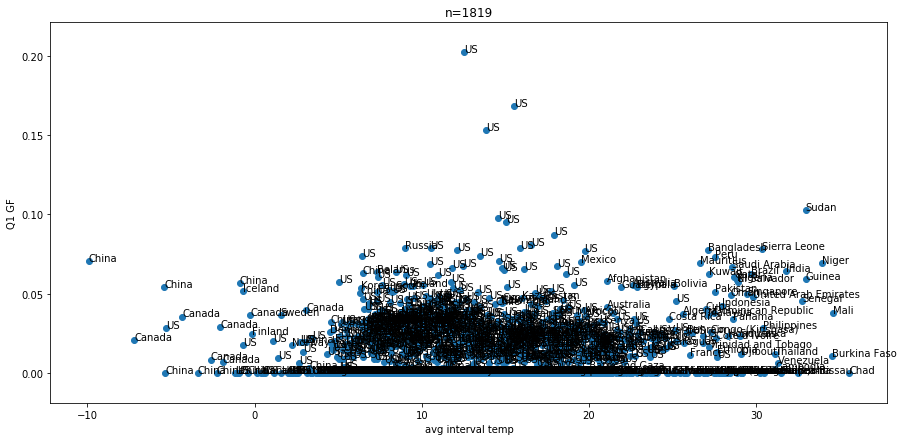

In [15]:
calc_corrs_scatter(**PLAIN)

###### No outliers - 0.02, 0.98

Interval temp vs GF_Q1 correlations
n=917
Pearson: -0.07073671135121815	One sided p_value: 0.01610433479508178
Spearman: -0.13095117672506862	One sided p_value: 3.486667206247696e-05

Interval temp vs GF_Q2 correlations
n=1419
Pearson: -0.034333632611432505	One sided p_value: 0.09807885816194888
Spearman: -0.05858752199743127	One sided p_value: 0.013659810796962423

Interval temp vs GF_Q3 correlations
n=1745
Pearson: -0.03084971600541224	One sided p_value: 0.09886003295116803
Spearman: -0.022760788084009265	One sided p_value: 0.17099702006947215

Interval temp vs first_7 correlations
n=1725
Pearson: -0.06544771783223371	One sided p_value: 0.003272069501808529
Spearman: -0.049637903069140954	One sided p_value: 0.019632767718827396



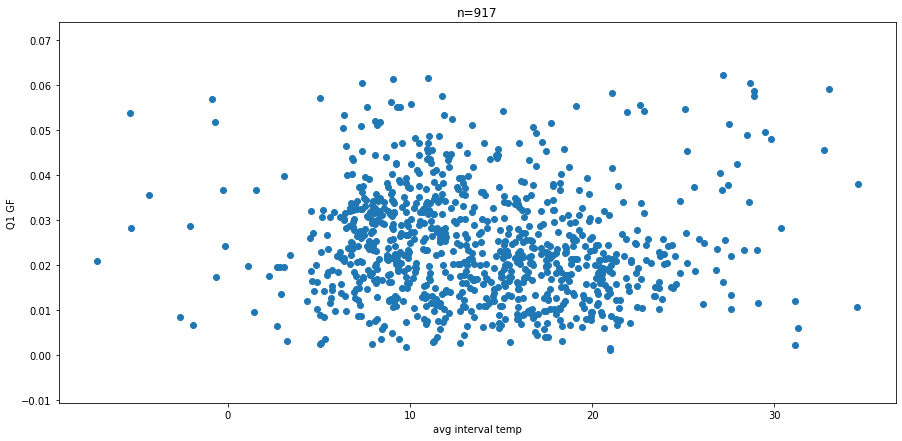

In [16]:
calc_corrs_scatter(**OUTLIERS)

###### GDP 30K, URB 80

Interval temp vs GF_Q1 correlations
n=311
Pearson: -0.09494008533261736	One sided p_value: 0.04732906200018283
Spearman: -0.11874831760115984	One sided p_value: 0.018168854044808603

Interval temp vs GF_Q2 correlations
n=432
Pearson: -0.05439915598564687	One sided p_value: 0.1296124916618588
Spearman: -0.05888089614515662	One sided p_value: 0.11098046657747392

Interval temp vs GF_Q3 correlations
n=504
Pearson: -0.014868228983736789	One sided p_value: 0.36957449432073536
Spearman: -0.004803486583620704	One sided p_value: 0.4571680542770046

Interval temp vs first_7 correlations
n=507
Pearson: 0.07444150430052439	One sided p_value: 0.04702987750568607
Spearman: 0.07029156019245167	One sided p_value: 0.05696413677697659



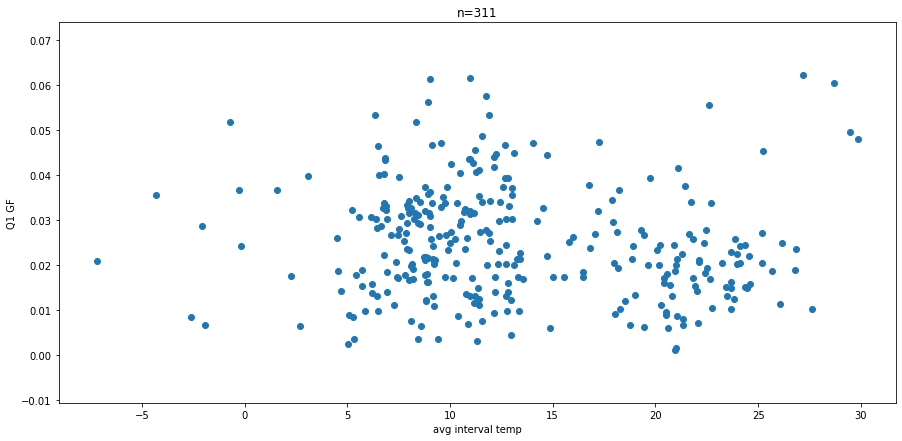

In [17]:
calc_corrs_scatter(**GDP_URB1)

###### GDP 36K, URB 84

Interval temp vs GF_Q1 correlations
n=283
Pearson: -0.13001668282366577	One sided p_value: 0.014377502980349283
Spearman: -0.1307208609795054	One sided p_value: 0.01394694635292515

Interval temp vs GF_Q2 correlations
n=392
Pearson: -0.052817105627685546	One sided p_value: 0.1484477300959215
Spearman: -0.0629544196428519	One sided p_value: 0.10680731225638955

Interval temp vs GF_Q3 correlations
n=457
Pearson: 0.0025568210732809862	One sided p_value: 0.47826482377015106
Spearman: 0.005858471685977444	One sided p_value: 0.45030219030326135

Interval temp vs first_7 correlations
n=457
Pearson: 0.10328368366813356	One sided p_value: 0.013628635572550611
Spearman: 0.08466267399091051	One sided p_value: 0.03528985955771599



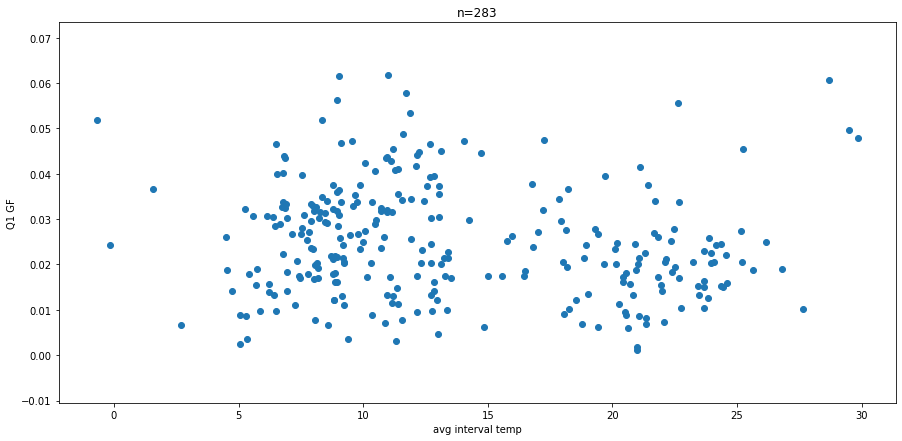

In [18]:
calc_corrs_scatter(**GDP_URB2)

###### GDP 43K, URB 88

Interval temp vs GF_Q1 correlations
n=152
Pearson: -0.26995798381522795	One sided p_value: 0.0003848578708276077
Spearman: -0.30477401144823585	One sided p_value: 6.734470706059787e-05

Interval temp vs GF_Q2 correlations
n=196
Pearson: -0.21899653098221294	One sided p_value: 0.0010216594505057088
Spearman: -0.2904068325516258	One sided p_value: 1.8214941292475624e-05

Interval temp vs GF_Q3 correlations
n=218
Pearson: -0.14394408965648758	One sided p_value: 0.016828176239862106
Spearman: -0.15853205101253515	One sided p_value: 0.00958852734206602

Interval temp vs first_7 correlations
n=220
Pearson: 0.02510936231334064	One sided p_value: 0.35555386159346436
Spearman: 0.03337324343067109	One sided p_value: 0.31124570218881653



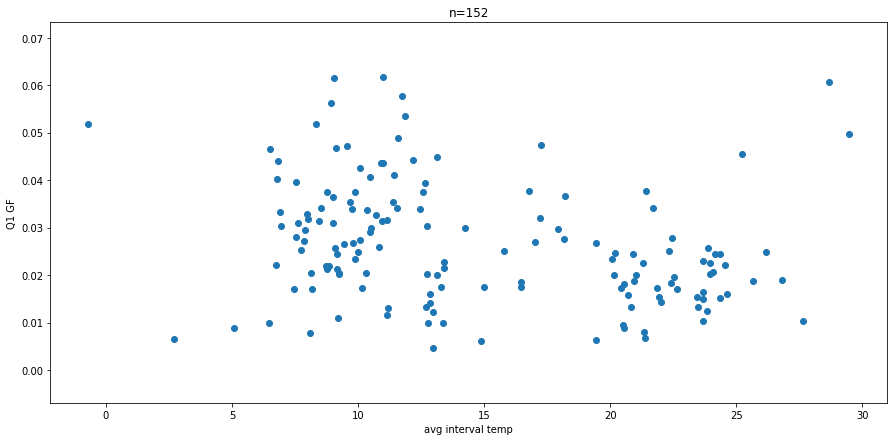

In [19]:
calc_corrs_scatter(**GDP_URB3)

###### US only

Interval temp vs GF_Q1 correlations
n=777
Pearson: -0.18252315803813016	One sided p_value: 1.506094517454196e-07
Spearman: -0.1888936167808211	One sided p_value: 5.642738078215718e-08

Interval temp vs GF_Q2 correlations
n=1246
Pearson: -0.08018575242210423	One sided p_value: 0.0023116239640847843
Spearman: -0.07532529659189054	One sided p_value: 0.00390705639321896

Interval temp vs GF_Q3 correlations
n=1556
Pearson: -0.018494684211963413	One sided p_value: 0.23299457941418467
Spearman: -0.005680158237871991	One sided p_value: 0.41142448088489664

Interval temp vs first_7 correlations
n=1525
Pearson: 0.012626607958106084	One sided p_value: 0.3111122453163773
Spearman: 0.005522312663426006	One sided p_value: 0.41469732558768274



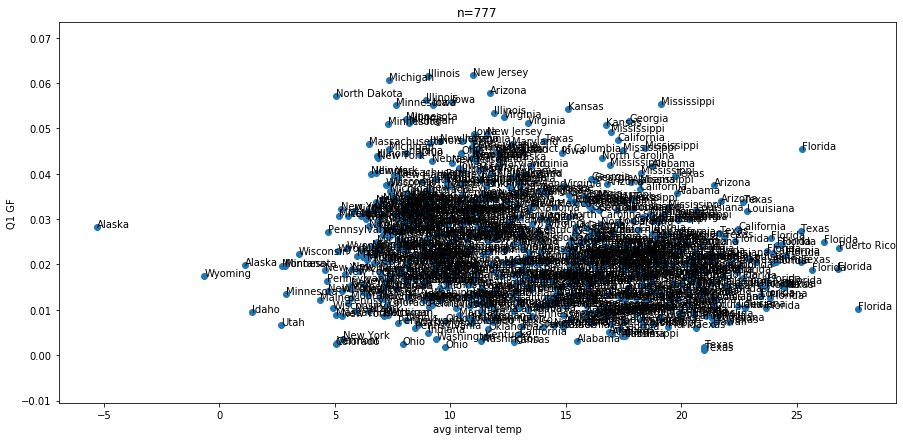

In [20]:
calc_corrs_scatter(**US_ONLY)

###### TEMP OUTLIERS 0.1, 0.9

Interval temp vs GF_Q1 correlations
n=733
Pearson: -0.22007496230311163	One sided p_value: 8.607460019497289e-10
Spearman: -0.22587663755868917	One sided p_value: 3.1041783556893966e-10

Interval temp vs GF_Q2 correlations
n=1135
Pearson: -0.12529020104134708	One sided p_value: 1.1527879166260937e-05
Spearman: -0.13401541552324406	One sided p_value: 2.94328192606835e-06

Interval temp vs GF_Q3 correlations
n=1395
Pearson: -0.02557807712449149	One sided p_value: 0.16988159359434699
Spearman: -0.03417931791737767	One sided p_value: 0.10101035203448061

Interval temp vs first_7 correlations
n=1379
Pearson: -0.014974807765194697	One sided p_value: 0.2892371393755962
Spearman: -0.017724619078029726	One sided p_value: 0.2553794245228028



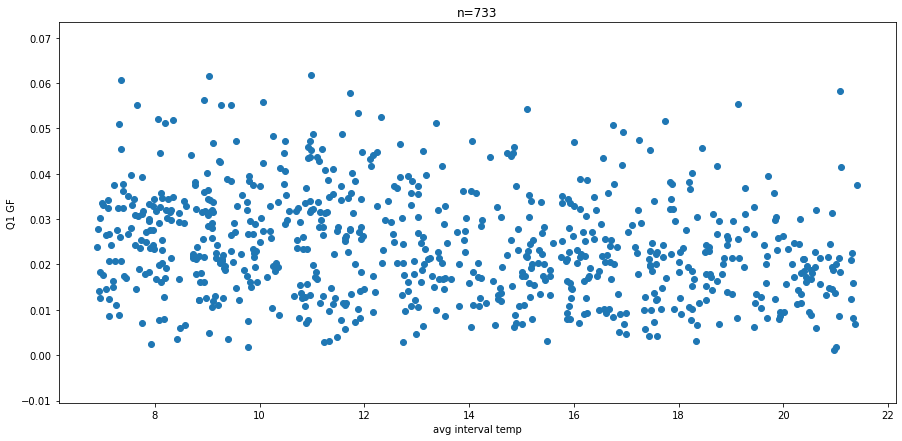

In [21]:
calc_corrs_scatter(**TEMP_OUTLIERS)

###### Rank sum
We regard two groups - 'cold' and 'hot' groups.
Each group's score is it's Q1 infection rate.
We will perform a Wilcoxon rank test and get a p-value for this arrangment

In [137]:
col = ['GF_Q1']
range_=(0.02,0.98)
gdp_th = 43000
urban_th = 88

NO_OUT = 'No Outliers'
WITH_OUT = 'With Outliers'
NO_TH = 'No TH'
WITH_TH = 'GDP and URBAN TH'


def gen_th_outliers(df):
    hopkins_gdp_urban_th = df[df['GDP'] >= gdp_th].copy()
    hopkins_gdp_urban_th = hopkins_gdp_urban_th[hopkins_gdp_urban_th['Urbanization'] >= urban_th].copy()
    hopkins_without_outliers = remove_outlier(df, range_, [col])
    hopkins_without_outliers.dropna(inplace=True)
    hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])
    return {
        'gdp_urban_th': hopkins_gdp_urban_th,
        'without_outliers': hopkins_without_outliers,
        'gdp_urban_th_no_outliers': hopkins_gdp_urban_th_no_outliers
    }

def calc_stats_tests(conf_df, cold, hot):

    colds = gen_th_outliers(cold)
    hots = gen_th_outliers(hot)
    
    # creating output df
    arrays = [['With Outliers', 'With Outliers', 'No Outliers', 'No Outliers'],\

          ['No TH','GDP and URBAN TH', \
           'No TH','GDP and URBAN TH']]
    idx = pd.MultiIndex.from_arrays(arrays, names=('Outliers', 'Thresholds'))
    stats_rslt = pd.DataFrame(index=idx)
    arrays_2 = [['Info on Distribution', 'Info on Distribution', 'Info on Distribution', 'Info on Distribution', 'WRS - builtin', 'WRS - builtin', 'TTest - builtin', 'TTest - builtin'], \
                ['Expected Mean', 'Attained Mean', 'Sigma', '(Expected - Attained)', 't statistic', 'p value', 't statistic', 'p value']]
    stats_rslt = stats_rslt.reindex(arrays_2, axis = 1)
    
    # dict for iterating over outlier/threshold cases
    df_dict = {
        'no_outliers_no_th': {
            'colds': colds['without_outliers'],
            'hots': hots['without_outliers'],
            'out': NO_OUT,
            'th': NO_TH
        },
        'no_outliers_urban_gdp_th': {
            'colds': colds['gdp_urban_th_no_outliers'],
            'hots': hots['gdp_urban_th_no_outliers'],
            'out': NO_OUT,
            'th': WITH_TH
        },
        'with_outliers_no_th': {
            'colds': cold,
            'hots': hot,
            'out': WITH_OUT,
            'th': NO_TH
        },
        'with_outliers_urban_gdp_th':  {
            'colds': colds['gdp_urban_th'],
            'hots': hots['gdp_urban_th'],
            'out': WITH_OUT,
            'th': WITH_TH
        }
    }
    
    
    for key in df_dict:
        curr_colds = df_dict[key]['colds']
        curr_hots = df_dict[key]['hots']
        out = df_dict[key]['out']
        th = df_dict[key]['th']

        result = manual_WRS('GF_Q1', curr_colds, curr_hots)

        stats_rslt.loc[(out, th),('Info on Distribution', 'Expected Mean')] = result['expected']
        stats_rslt.loc[(out, th),('Info on Distribution', 'Attained Mean')] = float(result['attained'])
        stats_rslt.loc[(out, th),('Info on Distribution', 'Sigma')] = int(result['sigma'])
        stats_rslt.loc[(out, th),('Info on Distribution', '(Expected - Attained)')] = float(result['attained']) - float(result['expected'])

        result = builtin_WRS('GF_Q1', curr_colds, curr_hots)
        stats_rslt.loc[(out, th),('WRS - builtin', 't statistic')] = float(result['t'])
        stats_rslt.loc[(out, th),('WRS - builtin', 'p value')] = float(result['p'])

        result = builtin_ttest('GF_Q1', curr_colds, curr_hots)
        stats_rslt.loc[(out, th),('TTest - builtin', 't statistic')] = float(result['t'])
        stats_rslt.loc[(out, th),('TTest - builtin', 'p value')] = float(result['p'])


    return stats_rslt

In [154]:
# handling na's and removing US-only columns
hopkins_confirmed_handled_nas = pd.read_pickle(PICKLE_PATH)
hopkins_confirmed_handled_nas.drop((37.0902, -95.7129), level=0, inplace=True)
hopkins_confirmed_handled_nas.drop(columns='Total Tests', inplace=True)
hopkins_confirmed_handled_nas.drop(columns='State Population', inplace=True)
hopkins_confirmed_handled_nas['Democracy'] = hopkins_confirmed_handled_nas['Democracy'].fillna(hopkins_confirmed_handled_nas['Democracy'].mean())
hopkins_confirmed_handled_nas['Tests \\ Pop'] = hopkins_confirmed_handled_nas['Tests \\ Pop'].fillna(0)
hopkins_confirmed_handled_nas['first_7'].dropna(inplace=True)
hopkins_confirmed_handled_nas['GDP'].dropna(inplace=True)
hopkins_confirmed_handled_nas['Urbanization'].dropna(inplace=True)


hopkins_confirmed_handled_nas.dropna(inplace=True)

In [155]:
tmps = hopkins_confirmed['avg_interval_tmp']
TEMPS = [(tmps.quantile(0.5), tmps.quantile(0.5)), (tmps.quantile(0.4), tmps.quantile(0.6)),\
         (tmps.quantile(0.3), tmps.quantile(0.7)), (tmps.quantile(0.2), tmps.quantile(0.8))]
TEMPS_dict = {
    '50_50': (tmps.quantile(0.5), tmps.quantile(0.5)),
    '40_60': (tmps.quantile(0.4), tmps.quantile(0.6)),
    '30_70': (tmps.quantile(0.3), tmps.quantile(0.7)),
    '20_80': (tmps.quantile(0.2), tmps.quantile(0.8))
}

results = {}

DATA = hopkins_confirmed_handled_nas
for tmp in TEMPS_dict.keys():
    TMP_DATA_COLD = DATA[DATA['avg_interval_tmp'] < TEMPS_dict[tmp][0]]
    TMP_DATA_HOT = DATA[DATA['avg_interval_tmp'] > TEMPS_dict[tmp][1]]
    results[tmp] = (calc_stats_tests(DATA, TMP_DATA_COLD, TMP_DATA_HOT))

for temp in TEMPS_dict.keys():
    print('Temperature quartile split: {0}'.format(temp))
    print('Temperature values: {:.2f}, {:.2f}'.format(TEMPS_dict[temp][0], TEMPS_dict[temp][1]))
    results[temp]
    print()



Temperature quartile split: 50_50
Temperature values: 13.44, 13.44


Info on Distribution                         \
                                      Expected Mean Attained Mean    Sigma   
Outliers      Thresholds                                                     
With Outliers No TH                        837682.5      869684.0  11302.0   
              GDP and URBAN TH              16077.0       17329.0    501.0   
No Outliers   No TH                        219897.0      237312.0   4033.0   
              GDP and URBAN TH               7680.0        8768.5    283.0   

                                                     WRS - builtin            \
                               (Expected - Attained)   t statistic   p value   
Outliers      Thresholds                                                       
With Outliers No TH                          32001.5      2.831364  0.004635   
              GDP and URBAN TH                1252.0      2.494672  0.012607   
No Outliers   No TH                          17415.0      4.317158  0.000016   
              GDP and URBAN TH                1088.5      3.833127  0.000127   

                               TTest - builtin            
                                   t statistic   p value  
Outliers      Thresholds                                  
With Outliers No TH                   2.147192  0.031909  
              GDP and URBAN TH        2.071986  0.039382  
No Outliers   No TH                   3.082546  0.002114  
              GDP and URBAN TH        3.606769  0.000416


Temperature quartile split: 40_60
Temperature values: 11.73, 15.09


Info on Distribution                        \
                                      Expected Mean Attained Mean   Sigma   
Outliers      Thresholds                                                    
With Outliers No TH                        536190.0      553255.0  8087.0   
              GDP and URBAN TH              10530.0       11633.5   388.0   
No Outliers   No TH                        150535.0      163069.5  3079.0   
              GDP and URBAN TH               5062.5        6092.5   223.0   

                                                     WRS - builtin            \
                               (Expected - Attained)   t statistic   p value   
Outliers      Thresholds                                                       
With Outliers No TH                          17065.0      2.109925  0.034865   
              GDP and URBAN TH                1103.5      2.840433  0.004505   
No Outliers   No TH                          12534.5      4.070221  0.000047   
              GDP and URBAN TH                1030.0      4.616409  0.000004   

                               TTest - builtin            
                                   t statistic   p value  
Outliers      Thresholds                                  
With Outliers No TH                   1.552278  0.120812  
              GDP and URBAN TH        2.528849  0.012248  
No Outliers   No TH                   2.941281  0.003367  
              GDP and URBAN TH        4.572250  0.000011


Temperature quartile split: 30_70
Temperature values: 10.07, 16.76


Info on Distribution                        \
                                      Expected Mean Attained Mean   Sigma   
Outliers      Thresholds                                                    
With Outliers No TH                        301675.5      309961.0  5253.0   
              GDP and URBAN TH               5508.0        6361.0   270.0   
No Outliers   No TH                         83953.5       90705.0  1996.0   
              GDP and URBAN TH               3080.0        3740.0   169.0   

                                                     WRS - builtin            \
                               (Expected - Attained)   t statistic   p value   
Outliers      Thresholds                                                       
With Outliers No TH                           8285.5      1.577023  0.114790   
              GDP and URBAN TH                 853.0      3.147623  0.001646   
No Outliers   No TH                           6751.5      3.380914  0.000722   
              GDP and URBAN TH                 660.0      3.892693  0.000099   

                               TTest - builtin            
                                   t statistic   p value  
Outliers      Thresholds                                  
With Outliers No TH                   1.072452  0.283753  
              GDP and URBAN TH        2.746343  0.006764  
No Outliers   No TH                   2.021362  0.043706  
              GDP and URBAN TH        3.764747  0.000271


Temperature quartile split: 20_80
Temperature values: 8.35, 18.61


Info on Distribution                        \
                                      Expected Mean Attained Mean   Sigma   
Outliers      Thresholds                                                    
With Outliers No TH                        134139.0      133191.0  2860.0   
              GDP and URBAN TH               1802.0        2202.5   146.0   
No Outliers   No TH                         35604.0       37945.5  1094.0   
              GDP and URBAN TH               1039.5        1316.5    92.0   

                                                     WRS - builtin            \
                               (Expected - Attained)   t statistic   p value   
Outliers      Thresholds                                                       
With Outliers No TH                           -948.0     -0.331410  0.740335   
              GDP and URBAN TH                 400.5      2.742658  0.006094   
No Outliers   No TH                           2341.5      2.138675  0.032462   
              GDP and URBAN TH                 277.0      3.006389  0.002644   

                               TTest - builtin            
                                   t statistic   p value  
Outliers      Thresholds                                  
With Outliers No TH                  -0.867249  0.386091  
              GDP and URBAN TH        2.260788  0.025875  
No Outliers   No TH                   0.609374  0.542637  
              GDP and URBAN TH        2.949114  0.004263

In [18]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_without_outliers, temp_range)




--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHOUT OUTLIERS
--------------------------------------------------


KeyError: 1

In [19]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])

print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th_no_outliers, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS
--------------------------------------------------


KeyError: 1

Text(0.5, 0, 'Average Interval Temperature')

Text(0, 0.5, 'Growth Factor')

NameError: name 'n' is not defined

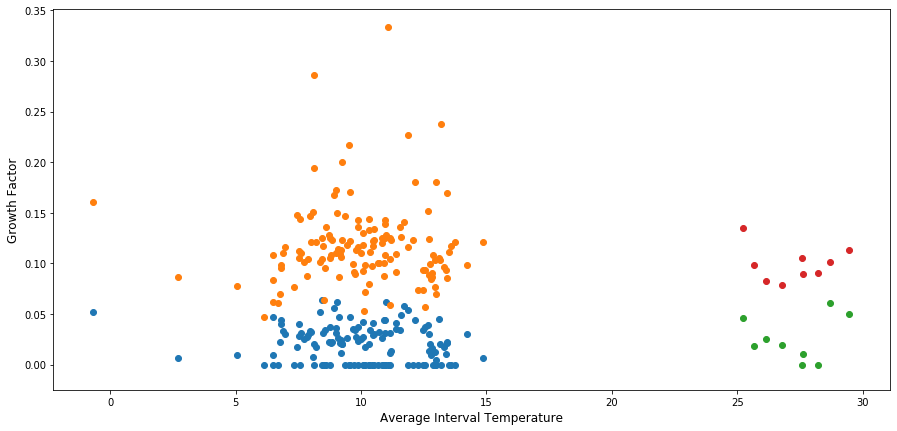

In [37]:
colds = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] <= 15][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
# print(colds.head())
colds = colds[colds['GDP'] > gdp_th]
colds = colds[colds['Urbanization'] > urban_th]


hots = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] >= 25][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['GDP'] >= gdp_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['Urbanization'] >= urban_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]


colds.reset_index(level=[0,1], drop=True, inplace=True)
hots.reset_index(level=[0,1], drop=True, inplace=True)

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q1'])
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q3'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q1'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITH OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')
# axes.text(7,  1.5556, 'Nebraska', fontsize='large')
# axes.text(9,  1.8571, 'Iowa', fontsize='large')
# plt.text(2,4,'This text starts at point (2,4)')

# without outliers
colds_no_outliers = remove_outlier(colds,range_, [col])
hots_no_outliers = remove_outlier(hots,range_, [col])

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q1'])
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q3'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q1'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITHOUT OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')

In [25]:
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_confirmed, temp_range)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITH OUTLIERS
--------------------------------------------------


TypeError: calc_wrs_ttest() missing 1 required positional argument: 'temp_range'

In [20]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 7371.0
Attained mean for cold countries rank sum:     7550.0
dtype: float64
Sigma: 99.13626985114983
(Attained mean) - (Expected mean) =     179.0
dtype: float64
p-value for this result is: 0.03549077520164401
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic:	1.8055954724619272
p-value:	0.035490775201643975
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic:	1.793167043226482
p-value:	0.03770182014580103
------------------------------------------------